In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import  seaborn as sns
import sklearn

%matplotlib inline

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder , PowerTransformer , MinMaxScaler

In [140]:
"""
[ YouTube API ]  --->  [ dataset_copy.csv ]
                             |
                             V
                    [ Thumbnail Script ] ---> [ dataset_thumbnail_featured.csv ]
                             |
                             V
                    [ Feature Engineering ] (Merge & Clean & Featuring)
                             |
                             V
                    [ data_featured.csv ]
                             |
                             V
                    [ ML Models ]

This is the roadmap of project and python files.
"""

'\n[ YouTube API ]  --->  [ dataset_copy.csv ]\n                             |\n                             V\n                    [ Thumbnail Script ] ---> [ dataset_thumbnail_featured.csv ]\n                             |\n                             V\n                    [ Feature Engineering ] (Merge & Clean & Featuring)\n                             |\n                             V\n                    [ data_featured.csv ]\n                             |\n                             V\n                    [ ML Models (XGBoost) ]\n\nThis is the roadmap of project and python files.\n'

In [120]:
# Load the Dataset
# Using sep=None and engine='python' to automatically detect the delimiter
data = pd.read_csv("data_featured.csv", sep=None, engine='python')

In [121]:
data

,video_title,duration_sec,is_shorts,views,upload_date,thumbnail_url,desc,tags,category,follower_count,default_language,video_id,has_manuel_subtitle,thumb_hue,thumb_saturation,thumb_brightness,thumb_r,thumb_g,thumb_b,thumb_hex,thumb_perceived_brightness,days_since_upload,upload_month,upload_year,publish_hour,publish_day_of_week,is_weekend,time_part_Afternoon,time_part_LateNight,time_part_Morning,time_part_Night,time_part_PrimeTime,title_length,title_word_count,title_uppercase_count,has_special_char,title_complexity,shout_factor,tag_count,desc_length,link_count,social_media_count,title_sentiment,reach_potential,follower_log,visual_pop,color_variety
0,IMG 0001 HD,2,1,42979,2017-07-30 14:53:27+00:00,https://i.ytimg.com/vi/3wL7dAN-C5Y/hqdefault.jpg,NaN,NaN,24,1380,ja,3wL7dAN-C5Y,False,0.000000,0.000000,0.000000,0,0,0,#000000,0.000,3051,7,2017,14,6,1,True,False,False,False,False,11,3,5,1,2.750000,0.500000,0,0,0,0,0.000000,15.253064,7.230563,0.000000,0.000000
1,IMG 0001,57,1,62953,2025-11-19 01:15:08+00:00,https://i.ytimg.com/vi/ufrc8t7NM5U/hqdefault.jpg,NaN,NaN,26,1250000,hi,ufrc8t7NM5U,False,352.075472,79.104478,26.274510,67,14,21,#430e15,30.645,18,11,2025,1,2,0,False,False,False,True,False,8,2,3,1,2.666667,0.444444,0,0,0,0,0.000000,16.929026,14.038655,24.241567,23.508864
2,IMG 0001,13,1,29751,2010-11-14 06:03:26+00:00,https://i.ytimg.com/vi/2r9TzHi7-cY/hqdefault.jpg,,"IMG, 0001",10,1200,en,2r9TzHi7-cY,False,0.000000,0.000000,0.000000,0,0,0,#000000,0.000,5502,11,2010,6,6,1,False,False,True,False,False,8,2,3,1,2.666667,0.444444,2,1,0,0,0.000000,15.702944,7.090910,0.000000,0.000000
3,IMG 0001,85,0,6443,2009-10-07 16:31:29+00:00,https://i.ytimg.com/vi/qMZQ78upXCc/hqdefault.jpg,1,"IMG, 0001",24,2360,en,qMZQ78upXCc,False,0.000000,0.000000,0.000000,0,0,0,#000000,0.000,5904,10,2009,16,2,0,True,False,False,False,False,8,2,3,1,2.666667,0.444444,2,1,0,0,0.000000,16.449802,7.766841,0.000000,0.000000
4,"IMG 0001- Boston, MA Skatepark",164,0,3475,2015-11-18 02:08:34+00:00,https://i.ytimg.com/vi/TItkIFA6GcQ/hqdefault.jpg,First couple days at the new Lynch skatepark i...,"east coast, LevitateSkate, LeavitateBrand, Lyn...",17,15,en,TItkIFA6GcQ,False,0.000000,0.000000,0.000000,0,0,0,#000000,0.000,3672,11,2015,2,2,0,False,False,False,True,False,30,5,7,1,5.000000,0.258065,4,185,0,0,0.000000,10.916560,2.772589,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13312,Poor Ronaldo Begged For Help what Happened Nes...,35,1,2913,2025-12-07 01:45:42+00:00,https://i.ytimg.com/vi/rw5Vs60PfRM/hqdefault.jpg,Poor Ronaldo Begged For Help what Happened Nes...,NaN,22,5270,unknown,rw5Vs60PfRM,False,200.000000,100.000000,1.176471,0,2,3,#000203,1.516,0,12,2025,1,6,1,False,False,False,True,False,86,13,9,1,6.142857,0.114943,0,162,0,0,-0.550000,0.000000,8.569975,1.516000,1.247219
13313,ronaldo ने दिया fastest Robot को चैलेंज 😱।Rona...,39,1,17244,2025-12-07 01:44:42+00:00,https://i.ytimg.com/vi/U6pld-KfO4Y/hqdefault.jpg,ronaldo ने दिया fastest Robot को चैलेंज 😱।Rona...,NaN,22,9560,unknown,U6pld-KfO4Y,False,180.000000,7.692308,5.098039,12,13,13,#0c0d0d,12.701,0,12,2025,1,6,1,False,False,False,True,False,87,8,2,1,9.666667,0.034091,0,87,0,0,0.000000,0.000000,9.165448,0.977000,0.471405
13314,"Messi,Neymar, Mbappé & Ronaldo vs Billionaire ...",23,1,17292,2025-12-07 01:38:42+00:00,https://i.ytimg.com/vi/YXq-DbROhRs/hqdefault.jpg,Watch Lionel Messi sprint across a war-torn fo...,NaN,1,467,en,YXq-DbROhRs,False,50.000000,35.294118,6.666667,17,16,11,#11100b,15.729,0,12,2025,1,6,1,False,False,False,True,False,99,13,10,1,7.071429,0.110000,0,599,0,0,0.166667,0.000000,6.148468,5.551412,2.624669
13315,ronaldo is a thief #messi #ronaldo #yshorts,60,1,3522,2025-12-07 01:31:26+00:00,https://i.ytimg.com/vi/HTPftSWBq6s/hqdefault.jpg,Ronaldo is a thief,NaN,22,268,unknown,HTPftSWBq6s,False,0.000000,5.882353,26.666667,68,64,64,#444040,65

In [122]:
#  Feature Selection
# Dropping high-cardinality strings, IDs, and the raw target column
drop_cols = ['video_title', 'upload_date', 'thumbnail_url', 'desc', 'tags',
             'video_id', 'thumb_hex', 'views','follower_count','thumb_r','thumb_g','thumb_b']

In [124]:
X = data.drop(columns=drop_cols)
# Log-transforming the target variable (views) to handle highly skewed distribution
y = np.log1p(data['views'])


In [125]:
# Handling Categorical Data
# Defining categorical columns for the HistGradientBoostingRegressor
categorical_cols = ['is_shorts', 'category', 'default_language',
                    'has_manuel_subtitle', ]

In [126]:
# Converting categories to numerical format using Ordinal Encoding
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_cols] = encoder.fit_transform(X[categorical_cols].astype(str))

In [127]:
for x in X.columns:
    print(x)

duration_sec
is_shorts
category
default_language
has_manuel_subtitle
thumb_hue
thumb_saturation
thumb_brightness
thumb_perceived_brightness
days_since_upload
upload_month
upload_year
publish_hour
publish_day_of_week
is_weekend
time_part_Afternoon
time_part_LateNight
time_part_Morning
time_part_Night
time_part_PrimeTime
title_length
title_word_count
title_uppercase_count
has_special_char
title_complexity
shout_factor
tag_count
desc_length
link_count
social_media_count
title_sentiment
reach_potential
follower_log
visual_pop
color_variety


In [129]:
# Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [130]:
# Model Configuration (HistGradientBoostingRegressor)
# Identify indices of categorical features for optimized processing
cat_idx = [X.columns.get_loc(col) for col in categorical_cols]

In [131]:
model = HistGradientBoostingRegressor(
    categorical_features=cat_idx,
    max_iter=1500,           # High number of iterations with early stopping
    learning_rate=0.04,      # Balanced learning rate for stability
    max_depth=15,            # Depth to capture complex non-linear relationships
    max_leaf_nodes=127,      # Higher capacity for identifying viral patterns
    min_samples_leaf=15,     # To avoid over-splitting on small samples
    l2_regularization=0.8,   # Preventing overfitting
    early_stopping=True,
    random_state=42
)

In [132]:
model.fit(X_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile'}, default='squared_error'The loss function to use in the boosting process. Note that the""squared error"", ""gamma"" and ""poisson"" losses actually implement""half least squares loss"", ""half gamma deviance"" and ""half poissondeviance"" to simplify the computation of the gradient. Furthermore,""gamma"" and ""poisson"" losses internally use a log-link, ""gamma""requires ``y > 0`` and ""poisson"" requires ``y >= 0``.""quantile"" uses the pinball loss... versionchanged:: 0.23 Added option 'poisson'... versionchanged:: 1.1 Added option 'quantile'... versionchanged:: 1.3 Added option 'gamma'.",'squared_error'
,"quantile quantile: float, default=NoneIf loss is ""quantile"", this parameter specifies which quantile to be estimatedand must be between 0 and 1.",None
,"learning_rate learning_rate: float, default=0.1The learning rate, also known as *shrinkage*. This is used as amultiplicative factor for the leaves values. Use ``1`` for noshrinkage.",0.04
,"max_iter max_iter: int, default=100The maximum number of iterations of the boosting process, i.e. themaximum number of trees.",1500
,"max_leaf_nodes max_leaf_nodes: int or None, default=31The maximum number of leaves for each tree. Must be strictly greaterthan 1. If None, there is no maximum limit.",127
,"max_depth max_depth: int or None, default=NoneThe maximum depth of each tree. The depth of a tree is the number ofedges to go from the root to the deepest leaf.Depth isn't constrained by default.",15
,"min_samples_leaf min_samples_leaf: int, default=20The minimum number of samples per leaf. For small datasets with lessthan a few hundred samples, it is recommended to lower this valuesince only very shallow trees would be built.",15
,"l2_regularization l2_regularization: float, default=0The L2 regularization parameter penalizing leaves with small hessians.Use ``0`` for no regularization (default).",0.8
,"max_features max_features: float, default=1.0Proportion of randomly chosen features in each and every node split.This is a form of regularization, smaller values make the trees weakerlearners and might prevent overfitting.If interaction constraints from `interaction_cst` are present, only allowedfeatures are taken into account for the subsampling... versionadded:: 1.4",1.0
,"max_bins max_bins: int, default=255The maximum number of bins to use for non-missing values. Beforetraining, each feature of the input array `X` is binned intointeger-valued bins, which allows for a much faster training stage.Features with a small number of unique values may use less than``max_bins`` bins. In addition to the ``max_bins`` bins, one more binis always reserved for missing values. Must be no larger than 255.",255
,"categorical_features categorical_features: array-like of {bool, int, str} of shape (n_features) or shape (n_categorical_features,), default='from_dtype'Indicates the categorical features.- None : no feature will be considered categorical.- boolean array-like : boolean mask indicating categorical features.- integer array-like : integer indices indicating categorical features.- str array-like: names of categorical features (assuming the training data has feature names).- `""from_dtype""`: dataframe columns with dtype ""category"" are considered to be categorical features. The input must be an object exposing a ``__dataframe__`` method such as pandas or polars DataFrames to use this feature.For each categorical feature, there must be at most `max_bins` uniquecategories. Negative values for categorical features encoded as numericdtypes are treated as missing values. All categorical values areconverted to floating point numbers. This means that categorical valuesof 1.0 and 1 are treated as the same category.Read more in the :ref:`User Guide ` and:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_categorical.py`... versionadded:: 0.24.. versionchanged:: 1.2 Added support for feature names... versionchanged::

In [133]:
# Evaluation and Comparison
# Predict on log-scale
preds_log = model.predict(X_test)
r2 = r2_score(y_test, preds_log)
print(f"R2 Score (Log Scale): {r2:.4f}")

R2 Score (Log Scale): 0.8870


In [134]:
# Inverse transform to original scale (actual view counts)
preds_real = np.expm1(preds_log)
y_test_real = np.expm1(y_test)
mae = mean_absolute_error(y_test_real, preds_real)
print(f"Mean Absolute Error (MAE): {mae:,.2f}")

# Create comparison table for the first 50 videos
comparison = pd.DataFrame({
    'Actual': y_test_real[:50].values.astype(int),
    'Predicted': preds_real[:50].astype(int)
})

print("\n--- First 50 Videos Comparison ---")
print(comparison)

Mean Absolute Error (MAE): 15,715,904.37

--- First 50 Videos Comparison ---
       Actual  Predicted
0        3742       1259
1   866480258   40482150
2    17591328    9104805
3         314       4167
4   159499425   19817696
5    16615467   30447699
6         629       3540
7     6951393     216733
8    77340043   22167020
9      650496   14385434
10    1333741      85244
11    1259647     231699
12       3386       1684
13       3976       5622
14       7964      26289
15   26095278   40452408
16       1380       2074
17     890649   19463061
18     438760     170635
19          2         27
20   56539648   59671704
21     759482       4418
22     192248       3679
23        283        353
24         25        238
25     389001     185464
26       3047        476
27   10846752   12686557
28    5102352    9589737
29       2849       1378
30    2680058   17605410
31   19388576    2099674
32    2265970    6975770
33    1060562     834313
34     601857    4332474
35       1918       107

In [136]:
# Check for Overfitting
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Training R2 Score: {train_score:.4f}")
print(f"Test R2 Score: {test_score:.4f}")
print(f"Gap: {train_score - test_score:.4f}")

Training R2 Score: 0.9505
Test R2 Score: 0.8870
Gap: 0.0636


In [137]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error

# Define custom scorer for MAE in real scale (since target is log-transformed)
def real_mae_scorer(y_true_log, y_pred_log):
    return mean_absolute_error(np.expm1(y_true_log), np.expm1(y_pred_log))

scoring = {
    'r2_log': 'r2',
    'mae_real': make_scorer(real_mae_scorer, greater_is_better=False)
}

# Configure Cross-Validation (5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Execute CV
cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)

# Display results
print(f"CV R2 (Log Scale): {cv_results['test_r2_log'].mean():.4f} (+/- {cv_results['test_r2_log'].std():.4f})")
print(f"CV MAE (Real Scale): {-cv_results['test_mae_real'].mean():,.2f}")

CV R2 (Log Scale): 0.8716 (+/- 0.0086)
CV MAE (Real Scale): 15,910,700.65


In [ ]:
from sklearn.inspection import permutation_importance

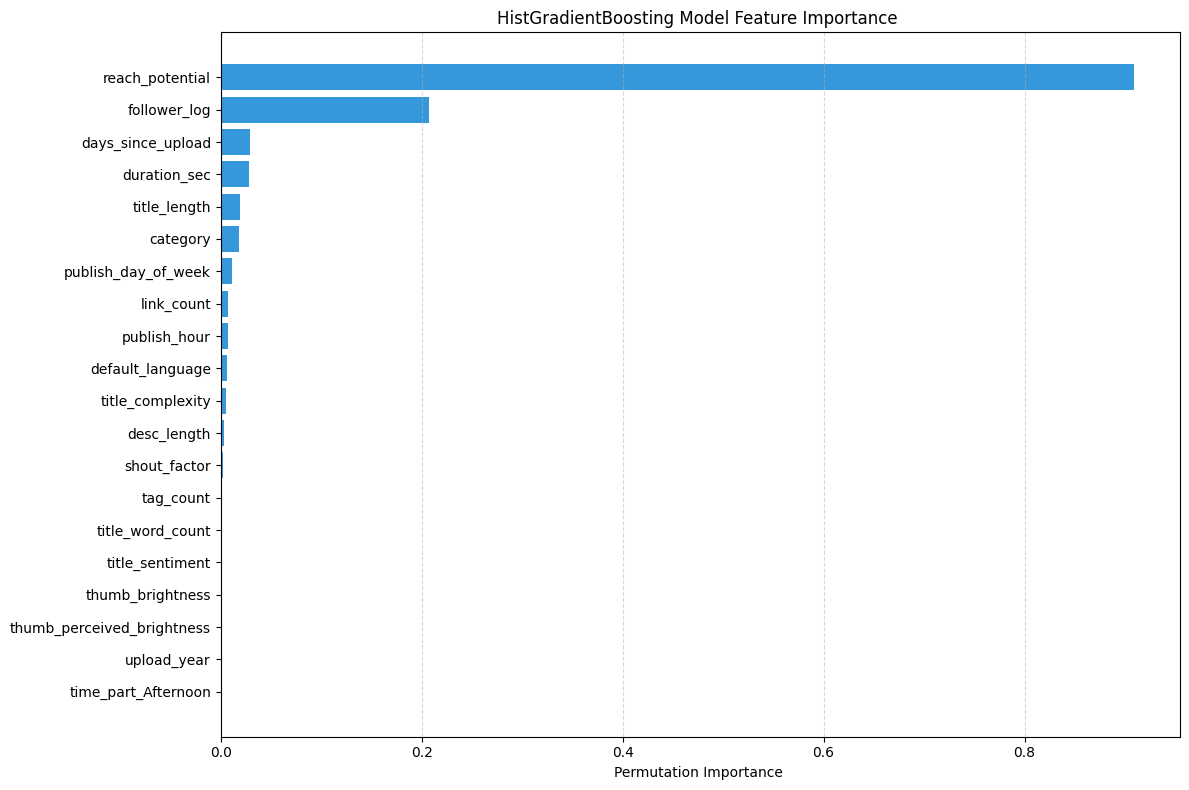

En Önemli Özellikler:
reach_potential: 0.9092
follower_log: 0.2073
days_since_upload: 0.0289
duration_sec: 0.0283
title_length: 0.0194
category: 0.0178
publish_day_of_week: 0.0112
link_count: 0.0075
publish_hour: 0.0074
default_language: 0.0059
title_complexity: 0.0048
desc_length: 0.0033
shout_factor: 0.0021
tag_count: 0.0012
title_word_count: 0.0010
title_sentiment: 0.0010
thumb_brightness: 0.0006
thumb_perceived_brightness: 0.0005
upload_year: 0.0004
time_part_Afternoon: 0.0004


In [ ]:
# Calculate permutation importance to determine which features have the most impact on the model's predictions
# n_repeats=10: The process is repeated 10 times to get a stable average importance score
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get the indices of the top 20 most important features by sorting the mean importance scores
sorted_idx = result.importances_mean.argsort()[-20:]

plt.figure(figsize=(12, 8))
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx], color='#3498db')
plt.xlabel("Permutation Importance")
plt.title("HistGradientBoosting Model Feature Importance")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Print the numerical importance scores for the top 20 features in descending order
print("Most Important Features:")
for i in sorted_idx[::-1]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f}")